In [1]:
%matplotlib inline
import importlib
from pytorch_utils_oh_2 import *
import IPython

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
MODEL_SAVE_PATH = 'whole_gen_10_after_words_attention'

In [5]:
import pytorch_utils_oh_2; importlib.reload(pytorch_utils_oh_2); from pytorch_utils_oh_2 import *;

Pytorch utils oh: pytorch_utils_oh_2.py
Pytorch: 0.2.0_4


# Data loading

In [6]:
# all_data = pickle.load(open("data/en_train_fixed_4_sentences.pkl", "rb" ))
all_data = pickle.load(open("data/en_train_fixed_5_manual.pkl", "rb" ))
# all_data_sentence_index = all_data.set_index('sentence_id')

In [7]:
sample_data = all_data.copy()
sample_data = sample_data[sample_data['class'] != 'NOT_CHANGED']
sample_data = sample_data[sample_data['class'] != 'MANUAL']
print("Data rows: {},  (dropped rows: {})".format(len(sample_data), len(all_data)-len(sample_data)))
sample_data = sample_data.reset_index(drop=True)
del(all_data)

Data rows: 654333,  (dropped rows: 9263859)


In [8]:
categories_all = sorted(sample_data["class"].unique())
print(categories_all)
print(len(categories_all))
categories_index = dict((c, i) for i, c in enumerate(categories_all))

['ELECTRONIC', 'LETTERS', 'NUMBERS', 'PLAIN', 'VERBATIM']
5


### Utils stuff

In [9]:
chars_normal, chars_normal_index = load_characters_pkl('data/en_features/chars_normal.pkl')
print(''.join(chars_normal))

<SOS><EOS>☒ !"#$%&'(),-./0123456789:;ABCDEFGHIJKLMNOPQRSTUVWXYZ_abcdefghijklmnopqrstuvwxyz~£¥ª²³µº¼½¾éɒʻˈΩμ—€⅓⅔⅛


common_words, common_words_index = load_common_words_10k()
len(common_words)
common_words[0:10]

In [10]:
wv_vecs, wv_words, wv_idx = load_glove('/home/ohu/koodi/data/glove_wordvec/glove.6B.50d.txt')

### After words handling

In [11]:
words_after_common = pickle.load(open("data/en_features/words_after_ext.pkl", 'rb'))
words_after_index = dict((c, i) for i, c in enumerate(words_after_common))
words_after_common[0:7]
len(words_after_common)

['<EOS>', '<SOS>', '<UNK>', '<0000>', '<SAMPLE>', 'two', 'twenty']

1351

In [12]:
#onehot_sos = torch.zeros(1, 1, len(words_after_index))
#onehot_sos[0, 0, words_after_index[SOS_TOKEN]] = 1
#onehot_sos.size()
#del(onehot_sos)

sos_tensor = torch.LongTensor([words_after_index[SOS_TOKEN]])

### More balanced sample

In [2]:
balanced_data_classes_select = list(sample_data.groupby('class'))

balanced_data_accessed_counter = 0 
balanced_data_randomize_freq = False
balanced_data_length = 0

def balanced_data_randomize(max_len=20000):
    global balanced_data, balanced_data_length, balanced_data_accessed_counter
    balanced_data = pd.concat([v.sample(min(max_len, len(v))) for k, v in balanced_data_classes_select])
    balanced_data_length = len(balanced_data)
    balanced_data_randomize_freq = balanced_data_length * 0.2
    balanced_data_accessed_counter = 0

def balanced_data_sample_row():
    global balanced_data_accessed_counter
    global balanced_data_last_sample
    balanced_data_accessed_counter += 1
    if balanced_data_randomize_setting and balanced_data_accessed_counter > balanced_data_randomize_setting:
        balanced_data_randomize()
    balanced_data_last_sample = balanced_data.iloc[random.randint(1, balanced_data_length-1)]
    return balanced_data_last_sample
    
balanced_data_randomize()

NameError: name 'sample_data' is not defined

In [14]:
#all_data.groupby('class')['class'].count()
#sample_data.groupby('class')['class'].count()
balanced_data.groupby('class')['class'].count()

class
ELECTRONIC     4964
LETTERS       20000
NUMBERS       20000
PLAIN         20000
VERBATIM      11741
Name: class, dtype: int64

In [15]:
 balanced_data_sample_row()

sentence_id                                         159847
token_id                                                 8
class                                                PLAIN
before                                                   -
after                                                   to
class_org                                            PLAIN
a_word_ind                                         [57, 0]
sentence       human ecology 32 ( 2 ) : 137 <SAMPLE> 162 .
Name: 139022, dtype: object

### Samples

In [16]:
def get_random_sample():
    sample_row = balanced_data_sample_row()
    sentence_id = sample_row['class']
    
    return sample_row['before'], sample_row['a_word_ind'], sample_row['class'], sample_row['sentence']
            
def tmp():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    s_aft_str = ' '.join([words_after_common[i] for i in s_aft])
    print(s_class, ':', s_bef, '->', s_aft_str, s_aft)
    print(s_sentence)
    print(string_to_tensor(s_bef, chars_normal_index).shape)
tmp()

VERBATIM : & -> and <EOS> [55, 0]
the barnes <SAMPLE> noble review .
torch.Size([1, 2, 104])


In [17]:
%%timeit
get_random_sample()

158 µs ± 4.78 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Model functions

In [18]:
use_cuda = True

In [ ]:
tmp = sample_data[sample_data['before'].str.len()>50]
len(tmp)
tmp.sample(2)
tmp[~tmp['before'].str.contains('/')].sample(2)

In [19]:
MAX_ATTENTION_LENGTH = 50

### Encoder

In [20]:
class EncoderRNN(nn.Module):
    def __init__(self, words_input_size, chars_input_size, words_hidden_size, chars_hidden_size,
                 words_layers=1, chars_layers=1):
        super(EncoderRNN, self).__init__()
        
        self.words_layers = words_layers
        self.chars_layers = chars_layers
        self.words_hidden_size = words_hidden_size
        self.chars_hidden_size = chars_hidden_size
        self.hidden_size = words_hidden_size + chars_hidden_size

        self.rnn_words = nn.LSTM(words_input_size, words_hidden_size // 2, words_layers,
                                 batch_first=True, bidirectional=True)

        self.rnn_chars = nn.LSTM(chars_input_size, chars_hidden_size // 2, chars_layers,
                                batch_first=True, bidirectional=True)
        
    def forward(self, word_vectors, string_tensor, hidden = None, init_hidden = True):
        if init_hidden:
            hidden_words, hidden_chars = self.init_hidden()
        
        all_outputs_words, hidden_words = self.rnn_words(word_vectors, hidden_words)
        output_words = all_outputs_words[:, -1]
        
        all_outputs_chars, hidden_chars = self.rnn_chars(string_tensor, hidden_chars)
        output_chars = all_outputs_chars[:, -1]
        
        hidden_states_cat = Variable(torch.zeros(MAX_ATTENTION_LENGTH, self.hidden_size)).cuda()
        for ei in range(min(MAX_ATTENTION_LENGTH, len(string_tensor[0]))):
            hidden_states_cat[ei] = torch.cat((output_words, all_outputs_chars[0, ei].view(1,-1)), 1)
                
        output = torch.cat((output_words[0], output_chars[0]), 0)

        #output = torch.cat((output_words, output_chars), 1)
        
        #return output, all_outputs_chars
        return output, hidden_states_cat

    def init_hidden(self):
        var1_1 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var1_2 = Variable(torch.zeros(2 * self.words_layers, 1, self.words_hidden_size // 2))
        var2_1 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        var2_2 = Variable(torch.zeros(2 * self.chars_layers, 1, self.chars_hidden_size // 2))
        
        var1_1 = var1_1.cuda(); var1_2 = var1_2.cuda()
        var2_1 = var2_1.cuda(); var2_2 = var2_2.cuda()
        return ((var1_1, var1_2), (var2_1, var2_2))
    
    
encoder_rnn = EncoderRNN(words_input_size=wv_vecs.shape[-1], chars_input_size=len(chars_normal),
                         words_hidden_size=128, chars_hidden_size=256,
                         words_layers=1, chars_layers=1).cuda()
encoder_rnn


EncoderRNN (
  (rnn_words): LSTM(50, 64, batch_first=True, bidirectional=True)
  (rnn_chars): LSTM(104, 128, batch_first=True, bidirectional=True)
)

In [21]:
def test_encoder_single_sample():
    s_bef, s_aft, s_class, s_sentence = get_random_sample()
    print(s_bef)
    
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    return encoder_rnn(words_t, string_t), s_bef
    
(encoder_output, encoder_outputs), tmp = test_encoder_single_sample()
tmp
encoder_output.size()
encoder_outputs.size()
torch.eq(encoder_output, encoder_outputs[len(tmp)]).data.all()

&


'&'

torch.Size([384])

torch.Size([50, 384])

True

### Decoder

In [22]:
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1, dropout_p=0.1, max_length=MAX_ATTENTION_LENGTH):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        
        #self.rnn = nn.GRU(input_size, hidden_size, n_layers,
        self.rnn = nn.GRU(hidden_size, hidden_size, n_layers,
                                 batch_first=True, bidirectional=False)
        
        self.lin_out = nn.Linear(hidden_size, input_size)
        #self.softmax = nn.LogSoftmax()
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.max_length = max_length
        self.attn = nn.Linear(hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        
    #def forward(self, char, hidden):
    def forward(self, last_input, hidden, encoder_outputs):
        embedded = self.embedding(last_input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        #IPython.core.debugger.Pdb().set_trace()
        #attn_weights = F.softmax(self.attn(torch.cat((char[0], hidden[0]), 1)))
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)))
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        
        output = F.relu(output)
        output, hidden = self.rnn(output, hidden)

        output = F.log_softmax(self.lin_out(output[0]))
        return output, hidden, attn_weights
    
    def init_rest_hidden(self, input_var):
        if self.n_layers > 1:
            hid_var = Variable(torch.zeros(self.n_layers - 1, 1, self.hidden_size)).cuda()
            res = torch.cat((input_var, hid_var), 0)
            return res
        else:
            return input_var
        

decoder_rnn = DecoderRNN(input_size=len(words_after_common), hidden_size=encoder_output.size()[0], n_layers=1)
decoder_rnn = decoder_rnn.cuda()
decoder_rnn

tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]

DecoderRNN (
  (rnn): GRU(384, 384, batch_first=True)
  (lin_out): Linear (384 -> 1351)
  (embedding): Embedding(1351, 384)
  (attn): Linear (768 -> 50)
  (attn_combine): Linear (768 -> 384)
  (dropout): Dropout (p = 0.1)
)

[torch.Size([1, 1351]), torch.Size([1, 1, 384]), torch.Size([1, 50])]

In [23]:
torch.bmm(torch.FloatTensor([1,0.1,0.1]).view(1,1,-1), torch.arange(0, 12).view(1,3,-1))


(0 ,.,.) = 
  1.2000  2.4000  3.6000  4.8000
[torch.FloatTensor of size 1x1x4]

In [24]:
tmp_outputs = Variable(torch.zeros(MAX_ATTENTION_LENGTH, encoder_output.size()[0])).cuda()
tmp_hiddens = decoder_rnn.init_rest_hidden(encoder_output.view(1,1,-1))
tmp = decoder_rnn(Variable(sos_tensor).cuda(), tmp_hiddens, tmp_outputs)
[v.size() for v in tmp]
print(tmp[0].topk(1)[1])
print(words_after_common[tmp[0].topk(1)[1].data[0][0]])

[torch.Size([1, 1351]), torch.Size([1, 1, 384]), torch.Size([1, 50])]

Variable containing:
 477
[torch.cuda.LongTensor of size 1x1 (GPU 0)]

francs


# Training etc

### Accuracy

In [34]:
def test_model_single_sample(model=None, return_more=False):
    decoder_rnn.eval()
    encoder_rnn.eval()
    
    s_bef, s_aft, s_class, s_sentence = sample = get_random_sample()
        
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()

    decoded_output = []
    decoder_attns_arr = []
    max_length = 20
    for _ in range(max_length):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)
        decoder_attns_arr.append(decoder_attns)
        #return decoder_output

        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
                
        if word == EOS_TOKEN:
            break

        decoded_output.append(word)
        
        decoder_input = Variable(torch.LongTensor([word_index])).cuda()
        
        #decoder_input = torch.zeros(1, 1, len(words_after_index))
        #decoder_input[0, 0, word_index] = 1
        #decoder_input = Variable(decoder_input).cuda()
    
    output = ' '.join(decoded_output)
    sample_target = ' '.join([words_after_common[w] for w in s_aft][:-1])
    
    decoder_rnn.train()
    encoder_rnn.train()
    
    if return_more:
        return output, decoded_output, decoder_attns_arr, sample
    
    return output, output, sample_target, sample
    
tmp = test_model_single_sample(None)
tmp

('ii killallmuslims killallmuslims month cafe cafe cafe cafe cafe cafe cafe cafe cafe cafe cafe cafe cafe cafe cafe cafe',
 'ii killallmuslims killallmuslims month cafe cafe cafe cafe cafe cafe cafe cafe cafe cafe cafe cafe cafe cafe cafe cafe',
 'and',
 ('&', [55, 0], 'VERBATIM', 'baskin <SAMPLE> battey .'))

In [26]:
def print_local_wrong_predictions(max_results=10):
    arr = get_some_wrong_predictions(None, test_model_single_sample, max_iterations=10000, max_results=max_results)
    for sample, predict, output in arr:
        s_bef, s_aft, s_class, s_sentence = sample
        print("{:<14} => {:<14} || {} \n{:>17} {}".format(s_bef, predict, s_aft, '', s_sentence, ))
print_local_wrong_predictions(2)

no             => ii ii ii ii ii hundred german german german german german german german german german german german german german german || [109, 0] 
                  florida historical quarterly <SAMPLE> 16 ( october 1937 ) .
-              => hundred hundred hundred hundred hundred hundred german german german german german german german german german german german german german german || [57, 0] 
                  91 , issue 342 <SAMPLE> 342 , pp .


In [27]:
%%time
test_model_accuracy(encoder_rnn, test_model_single_sample, n_sample=100)

Accuracy: 0.00% (       0/     100)
CPU times: user 2.35 s, sys: 56 ms, total: 2.41 s
Wall time: 2.41 s


0.0

### Training

In [35]:
def train(s_bef, s_aft, s_sentence, encoder_optimizer, decoder_optimizer, loss_function,
          use_teacher_forcing, max_length=20):
    
    words_t = Variable(words_to_word_vectors_tensor(list(s_sentence), wv_vecs, wv_idx)).cuda()
    
    string_t = string_to_tensor(s_bef, chars_normal_index)
    string_t = Variable(string_t).cuda()
    
    encoder_output, encoder_outputs = encoder_rnn(words_t, string_t)
    
    #encoder_output = encoder_output.view(1,1,-1)
    
    decoder_hidden = decoder_rnn.init_rest_hidden(encoder_outputs[0].view(1,1,-1))
    decoder_input = Variable(sos_tensor).cuda()
    
    ###
    target_arr = s_aft
    #target_arr = after_sentence_to_word_indexes(s_aft, include_eos=True)
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    loss = 0
    
    decoded_output = []
    for i in range(len(target_arr)):
        decoder_output, decoder_hidden, decoder_attns = decoder_rnn(decoder_input, decoder_hidden, encoder_outputs)

        #decoder_target_i = chars_after_index[target_arr[i]]
        decoder_target_i = target_arr[i]
        decoder_target_i = Variable(torch.LongTensor([decoder_target_i])).cuda()
        loss += loss_function(decoder_output, decoder_target_i)
        
        topv, topi = decoder_output.data.topk(1)
        word_index = topi[0][0]
        word = words_after_common[word_index] # Use own prediction as next input
        decoded_output.append(word)
        
        if use_teacher_forcing:
            word_index = target_arr[i] # replace input with right target
        else:
            # use output normally as input 
            if word == EOS_TOKEN:
                break
                
        decoder_input = Variable(torch.LongTensor([word_index])).cuda()
        
    if decoded_output[-1] == EOS_TOKEN:
        decoded_output = decoded_output[:-1]
        
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return ' '.join(decoded_output), (loss.data[0] / len(target_arr))


In [36]:
def train_iterations(n_iters=100000, lr=0.001, teacher_forcing_ratio=0.5,
                     print_every=10000, plot_every=1000):

    start = time.time()
    
    decoder_rnn.train()
    encoder_rnn.train()

    current_loss = 0
    current_loss_iter = 0

    encoder_optimizer = torch.optim.Adam(encoder_rnn.parameters(), lr=lr)
    decoder_optimizer = torch.optim.Adam(decoder_rnn.parameters(), lr=lr)
    loss_function = nn.NLLLoss()
    
    for iteration in range(1, n_iters + 1):
        model_training.iterations += 1
        
        use_teacher_forcing = random.random() < teacher_forcing_ratio
        
        s_bef, s_aft, s_class, s_sentence = get_random_sample()
        
        result, loss = train(s_bef=s_bef, s_aft=s_aft, s_sentence=s_sentence,
                             encoder_optimizer=encoder_optimizer, decoder_optimizer=decoder_optimizer,
                             loss_function=nn.NLLLoss(), use_teacher_forcing=use_teacher_forcing,
                             max_length=40 )
        
        current_loss += loss
        current_loss_iter += 1

        # Print iter number, loss, name and guess
        if iteration % print_every == 0:
            teacher_forcing_str = ""
            if use_teacher_forcing:
                teacher_forcing_str = "(forcing)"
            s_aft_sentence = ' '.join([words_after_common[w] for w in s_aft][:-1])
            correct = '✓' if result == s_aft_sentence else "✗: {}".format(s_aft)
            
            print("{:>6d} {:>4.0%} ({:>8}) {:>7.3f}   | {:>6.2f}: {} -> {} ({}) {}".format(
                      model_training.iterations, iteration/n_iters, time_since(start),
                      current_loss/current_loss_iter, loss,
                      s_bef, result, correct, teacher_forcing_str))

        # Add current loss avg to list of losses
        if iteration % plot_every == 0:
            model_training.losses.append(current_loss / plot_every)
            model_training.learning_rates.append(lr)
            current_loss = 0
            current_loss_iter = 0
            
        if model_training.iterations % 50000 == 0 or model_training.iterations == 10:
            model_training.save_models()
            acc = test_model_accuracy(encoder_rnn, test_model_single_sample)
            model_training.accuracy.append(acc)
    
    # test_model_accuracy(model, n_sample=10000)

In [37]:
model_training = ModelTraining(MODEL_SAVE_PATH, [encoder_rnn, decoder_rnn])

Save path: data/models/whole_gen_10_after_words_attention


In [38]:
train_iterations(n_iters=50, print_every=9, lr=0.0001)

     9  18% (   0m 0s)   6.749   |   3.59: 1853 -> e (✗: [40, 38, 13, 0]) 
Saved model to data/models/whole_gen_10_after_words_attention/10_(EncoderRNN/DecoderRNN)
Accuracy: 0.00% (       0/   10000)
    18  36% (  0m 47s)   5.805   |   1.44: November 4, 2014 ->  (✗: [69, 77, 6, 50, 0]) 
    27  54% (  0m 47s)   5.209   |   1.76: 1964 ->  (✗: [7, 39, 19, 0]) 
    36  72% (  0m 47s)   5.228   |   6.53: 2 -> <EOS> (✗: [5, 0]) (forcing)
    45  90% (  0m 47s)   4.856   |   3.59: 11 ->  (✗: [48, 0]) 


In [39]:
train_iterations(n_iters=(1000-model_training.iterations), print_every=500, lr=0.0001)

   550  53% (   0m 9s)   3.082   |   5.10: #VII -> and (✗: [175, 247, 1100, 0]) 


In [40]:
train_iterations(n_iters=9000, lr=0.0001, print_every=1000)

  2000  11% (  0m 18s)   2.562   |   2.78: 10 -> to (✗: [44, 0]) (forcing)
  3000  22% (  0m 42s)   2.322   |   1.81: centre -> nineteen (✗: [110, 0]) (forcing)
  4000  33% (   1m 4s)   2.283   |   2.18: DC -> u <EOS> (✗: [26, 21, 0]) (forcing)
  5000  44% (  1m 26s)   2.223   |   3.18: Dialogue -> the (✗: [200, 0]) 
  6000  56% (  1m 48s)   2.080   |   1.75: Sp -> p p (✗: [17, 24, 0]) (forcing)
  7000  67% (  2m 10s)   1.983   |   1.55: 2005 -> nineteen seventy eight (✗: [5, 8, 14, 0]) 
  8000  78% (  2m 33s)   1.987   |   2.24: 4 -> number (✗: [19, 0]) (forcing)
  9000  89% (  2m 55s)   1.898   |   0.02: & -> and (✓) 
 10000 100% (  3m 16s)   1.944   |   1.67: metres -> center (✗: [108, 0]) 


In [41]:
train_iterations(n_iters=90000, print_every=10000)

 20000  11% (  3m 39s)   1.122   |   3.49: lawsociety.ie -> b e s l a s h e s l a s h e (✗: [42, 22, 52, 17, 25, 21, 31, 28, 30, 86, 74, 31, 28, 0]) 
 30000  22% (  7m 35s)   0.855   |   0.00: & -> and (✓) 
 40000  33% ( 11m 18s)   0.737   |   0.55: PhD -> p d d (✗: [24, 45, 26, 0]) (forcing)
 50000  44% ( 14m 59s)   0.673   |   0.00: - -> to (✓) (forcing)
Saved model to data/models/whole_gen_10_after_words_attention/50000_(EncoderRNN/DecoderRNN)
Accuracy: 67.36% (    6736/   10000)
 60000  56% (  20m 9s)   0.657   |   0.00: & -> and (✓) (forcing)
 70000  67% ( 23m 56s)   0.675   |   0.00: - -> to (✓) (forcing)
 80000  78% ( 27m 50s)   0.631   |   1.15: ISEE- -> i e e <EOS> (✗: [31, 17, 28, 28, 0]) (forcing)
 90000  89% ( 31m 37s)   0.572   |   0.02: # -> number (✓) (forcing)
100000 100% ( 35m 18s)   0.627   |   0.12: F.C. -> f c (✓) 
Saved model to data/models/whole_gen_10_after_words_attention/100000_(EncoderRNN/DecoderRNN)
Accuracy: 71.84% (    7184/   10000)


In [79]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.001)

110095   5% (  3m 42s)   0.588   |   0.96: NLRB -> n b r <EOS> (✗: [29, 42, 35, 36, 0]) (forcing)
120095  10% (  7m 23s)   0.591   |   0.00: & -> and (✓) 
130095  15% (  11m 5s)   0.520   |   0.31: JDL -> j d l (✓) 
140095  20% ( 14m 56s)   0.594   |   0.00: & -> and (✓) 
Saved model to data/models/whole_gen_10_after_words_attention/150000_(EncoderRNN/DecoderRNN)
Accuracy: 74.33% (    7433/   10000)
150095  25% (  20m 2s)   0.522   |   0.00: - -> to (✓) 
160095  30% ( 23m 39s)   0.510   |   0.00: Centre -> center (✓) 
170095  35% ( 27m 35s)   0.472   |   3.14: 55.93% -> fifty seven point three percent (✗: [38, 14, 46, 15, 13, 83, 0]) 
180095  40% ( 31m 23s)   0.506   |   0.00: Organisation -> organization (✓) 
190095  45% ( 35m 18s)   0.543   |   0.00: - -> to (✓) (forcing)
Saved model to data/models/whole_gen_10_after_words_attention/200000_(EncoderRNN/DecoderRNN)
Accuracy: 74.77% (    7477/   10000)
200095  50% ( 40m 50s)   0.541   |   0.00: mr -> mister (✓) 
210095  55% ( 44m 48s)  

In [80]:
print_local_wrong_predictions()

OldRacingCars.com => o d i n s dot c o m || [25, 42, 26, 35, 22, 21, 31, 29, 53, 21, 22, 35, 17, 74, 21, 25, 32, 0] 
                  " thruxton , 31 mar 1975 « british formula 3 « <SAMPLE> " .
TCTapes.net    => t p s a n d p a s p p p p p p p p p p p || [30, 21, 30, 22, 24, 28, 17, 74, 29, 28, 30, 0] 
                  united states : <SAMPLE> .
EGC            => e c g          || [28, 53, 21, 0] 
                  one of the best known <SAMPLE> graduates is queen sofia of spain .
BentleyPublishers.com => b l e s q s p s c o s q y n y s p n s p || [36, 28, 29, 30, 42, 28, 86, 24, 43, 36, 42, 31, 17, 45, 28, 35, 17, 74, 21, 25, 32, 0] 
                  cambridge massachusetts : <SAMPLE> .
fictionalised  => october k      || [576, 0] 
                  in 2010 , he appeared as a <SAMPLE> version of himself in the controversial movie killer bitch .
Elzén          => e acute acute acute acute acute acute acute acute acute acute acute acute acute acute acute acute acute acute acute || [2

In [81]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.3, lr=0.001)

310095   5% (  3m 40s)   0.480   |   0.19: 2nd -> second (✓) 
320095  10% (  7m 21s)   0.419   |   0.00: Vol -> volume (✓) (forcing)
330095  15% (  11m 3s)   0.429   |   0.00: centre -> center (✓) 
340095  20% ( 14m 44s)   0.520   |   0.03: # -> number (✓) 
Saved model to data/models/whole_gen_10_after_words_attention/350000_(EncoderRNN/DecoderRNN)
Accuracy: 78.88% (    7888/   10000)
350095  25% ( 19m 51s)   0.399   |   0.00: _ -> underscore (✓) 
360095  30% ( 23m 30s)   0.419   |   0.00: & -> and (✓) 
370095  35% (  27m 9s)   0.516   |   0.00: J- -> j (✓) 
380095  40% ( 30m 46s)   0.501   |   0.05: ISBN -> i s b n (✓) 
390095  45% ( 34m 22s)   0.467   |   0.00: & -> and (✓) 
Saved model to data/models/whole_gen_10_after_words_attention/400000_(EncoderRNN/DecoderRNN)
Accuracy: 76.44% (    7644/   10000)
400095  50% ( 39m 19s)   0.401   |   0.01: 29 -> twenty nine (✓) 
410095  55% (  43m 6s)   0.469   |   2.24: Defense.gov -> d e s f o n e s e n s e (✗: [26, 28, 37, 28, 29, 17, 28, 74,

In [82]:
print_local_wrong_predictions()

NCA            => n a c          || [29, 21, 22, 0] 
                  with tiebout 's support , she founded the national council on alcoholism ( <SAMPLE> ) .
R.A.F.         => r f a          || [35, 22, 37, 0] 
                  " shindig at n . y . airport opens fund drive for <SAMPLE> " .
DVD            => d v            || [26, 54, 26, 0] 
                  sleeve notes from <SAMPLE> .
12.1           => twelve point one point one point one point one point one point one point one point one point one point || [47, 46, 9, 0] 
                  das heilige und die kultformen , grundriss der germanischen philologie <SAMPLE> , 2nd ed .
RNAs           => r v's a n a t a n a n a n a n a n a n a n || [35, 29, 142, 0] 
                  these short double stranded fragments are called small interfering <SAMPLE> ( sirnas ) .
http://www.kuvataiteilijamatrikkeli.fi/fi/taiteilijat/1449 => h t j p colon o v i o v i o v i o v i o v i || [45, 30, 30, 24, 129, 101, 101, 52, 52, 52, 74, 59, 43, 54, 2

In [83]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.5, lr=0.0001)

510095  10% (  3m 40s)   0.375   |   0.56: JBEI -> j b e i (✓) 
520095  20% (  7m 17s)   0.300   |   2.04: TheCelebrityCafe.com -> t h e e e e e e e e e e e e h e e c o m e (✗: [30, 45, 28, 21, 28, 42, 28, 36, 35, 31, 30, 86, 21, 22, 37, 28, 74, 21, 25, 32, 0]) (forcing)
530095  30% ( 10m 56s)   0.296   |   0.01: st -> saint (✓) (forcing)
540095  40% ( 14m 35s)   0.325   |   0.02: st -> saint (✓) (forcing)
Saved model to data/models/whole_gen_10_after_words_attention/550000_(EncoderRNN/DecoderRNN)
Accuracy: 83.38% (    8338/   10000)
550095  50% ( 19m 43s)   0.307   |   0.01: 1960 -> nineteen sixty (✓) 
560095  60% ( 23m 29s)   0.277   |   0.00: Theatre -> theater (✓) (forcing)
570095  70% ( 27m 13s)   0.303   |   0.01: st -> saint (✓) (forcing)
580095  80% ( 30m 53s)   0.313   |   0.00: criticised -> criticized (✓) 
590095  90% ( 34m 30s)   0.311   |   0.01: 1978 -> nineteen seventy eight (✓) (forcing)
Saved model to data/models/whole_gen_10_after_words_attention/600000_(EncoderRNN/De

In [84]:
print_local_wrong_predictions()

USPACOM        => u s p o m      || [43, 17, 24, 22, 21, 25, 32, 0] 
                  the us army contingent is from the us army pacific ( usarpac ) , part of the united states pacific command ( <SAMPLE> ) .
Brisbanetimes.com.au => b r b a s i n dot c o m || [36, 35, 31, 17, 36, 22, 29, 28, 30, 31, 32, 28, 17, 74, 21, 25, 32, 74, 22, 43, 0] 
                  <SAMPLE> ( 19 august 2010 ) .
PKM            => p k            || [24, 59, 32, 0] 
                  it can also accept all standard <SAMPLE> accessories , including tripod mount , and 100 - round clip on belt boxes .
CatholicCulture.org => c a t t t t t t t t t t t t t t t t t t || [21, 22, 30, 45, 25, 42, 31, 21, 21, 43, 42, 30, 43, 35, 28, 74, 25, 35, 53, 0] 
                  <SAMPLE> ( trinity communications ) .
.254           => point two five || [46, 5, 14, 19, 0] 
                  isbn 978 - 1 - 86969 - 366 - 4 , p <SAMPLE> .
Egm            => e g g g g g g g g g g g g g g g g g g g || [28, 53, 32, 0] 
                  

In [85]:
train_iterations(n_iters=100000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.001)

610095  10% (  3m 41s)   0.526   |   1.57: ECTRIMS -> e r s c (✗: [28, 21, 30, 35, 31, 32, 17, 0]) 
620095  20% (  7m 19s)   0.469   |   0.33: 385 -> three hundred eighty five eighty (✗: [13, 10, 27, 14, 0]) 
630095  30% ( 10m 47s)   0.449   |   0.02: F. -> f (✓) 
640095  40% ( 14m 18s)   0.503   |   0.02: 1961 -> nineteen sixty one (✓) 
Saved model to data/models/whole_gen_10_after_words_attention/650000_(EncoderRNN/DecoderRNN)
Accuracy: 79.42% (    7942/   10000)
650095  50% ( 19m 14s)   0.379   |   0.00: 1994 -> nineteen ninety four (✓) 
660095  60% ( 22m 57s)   0.482   |   2.46: 978-1-57912-313-0 -> nine seven sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil (✗: [15, 18, 16, 58, 9, 58, 14, 18, 15, 9, 5, 58, 13, 9, 13, 58, 25, 0]) 
670095  70% ( 26m 34s)   0.485   |   0.00: metres -> meters (✓) 
680095  80% ( 30m 16s)   0.444   |   0.02: 360 -> three hundred sixty (✓) 
690095  90% ( 33m 52s)   0.407   |   0.03: PDF -> p d f (✓) 
Saved model to data/models/whole_gen_10

In [86]:
print_local_wrong_predictions()

M. A. C.       => m c            || [32, 22, 21, 0] 
                  perryman , <SAMPLE> et al .
2500           => two thousand five || [5, 8, 14, 10, 0] 
                  total number of population in this village is close to <SAMPLE> .
Catholic.org   => c a o t h r dot o g || [21, 22, 30, 45, 25, 42, 31, 21, 74, 25, 35, 53, 0] 
                  " <SAMPLE> information web site for hong kong " .
1980           => nineteen eighty || [9, 8, 15, 10, 27, 0] 
                  two day ( 15 ) : 1927 / 28 , 1928 / 29 , 1935 / 36 , 1939 / 40 , 1957 / 58 , <SAMPLE> / 81 , 1982 / 83 , 1985 / 86 , 1986 / 87 , 1987 / 88 , 1990 / 91 , 1991 / 92 , 2009 / 10 , 2010 / 11 and 2011 / 12 .
M.C.C.         => m c            || [32, 21, 21, 0] 
                  his first class debut came ten years later when he played for the <SAMPLE> against lancashire .
1718           => seventeen eighteen seventeen || [81, 40, 0] 
                  they returned to power with the election of manuel ii following the 

In [87]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.0005)

710095   5% (  3m 45s)   0.384   |   0.00: Centre -> center (✓) 
720095  10% (  7m 27s)   0.379   |   0.00: Organisation -> organization (✓) 
730095  15% (  11m 9s)   0.390   |   2.47: 3-17-003263-1 -> three sil o one sil one one one one one one one one one (✗: [13, 58, 9, 18, 58, 25, 25, 13, 5, 20, 13, 58, 9, 0]) 
740095  20% ( 14m 49s)   0.368   |   0.00: W. -> w (✓) 
Saved model to data/models/whole_gen_10_after_words_attention/750000_(EncoderRNN/DecoderRNN)
Accuracy: 82.80% (    8280/   10000)
750095  25% ( 19m 51s)   0.386   |   0.00: 3 -> three (✓) (forcing)
760095  30% ( 23m 28s)   0.325   |   0.03: 221 -> two hundred twenty one (✓) 
770095  35% ( 27m 12s)   0.292   |   0.01: AJ -> a j (✓) 
780095  40% ( 30m 58s)   0.399   |   0.00: 2008 -> two thousand eight (✓) 
790095  45% ( 34m 37s)   0.343   |   0.02: 1963 -> nineteen sixty three (✓) 
Saved model to data/models/whole_gen_10_after_words_attention/800000_(EncoderRNN/DecoderRNN)
Accuracy: 82.18% (    8218/   10000)
800095  50%

In [88]:
print_local_wrong_predictions()

MGNREGA        => m g n g e g g g g g g g g g g g g g g g || [32, 53, 29, 35, 28, 53, 22, 0] 
                  " mihir shah committee proposes new guidelines on <SAMPLE> : some highlights " .
12/03/07       => the third of march o || [11, 76, 12, 65, 25, 18, 0] 
                  " weekly list of actions taken on properties <SAMPLE> through 12 / 07 / 07 " , national register of historic places , national park service .
Amazon.com     => a m a z o n dot c o || [22, 32, 22, 105, 25, 29, 74, 21, 25, 32, 0] 
                  <SAMPLE> ( us ) amazon . com inc retrieved 2013 - 01 - 25 .
38.6           => thirty point six || [34, 16, 46, 20, 0] 
                  the median age was <SAMPLE> years .
talkfootball.co.uk => t a l k dot c o dot c o dot c o dot c o dot c o dot || [30, 22, 42, 59, 37, 25, 25, 30, 36, 22, 42, 42, 74, 21, 25, 74, 43, 59, 0] 
                  positions in football : sweeper / libero <SAMPLE> , accessed 11 july 2010 ramesh , priya .
AACo           => a c a a a a a a a

In [89]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0.1, lr=0.0001)

910095   3% (  3m 39s)   0.274   |   0.00: & -> and (✓) (forcing)
920095   7% (  7m 22s)   0.347   |   0.00: - -> to (✓) 
930095  10% ( 10m 58s)   0.305   |   6.40: fertilises -> third (✗: [1122, 0]) 
940095  13% ( 14m 41s)   0.220   |   0.00: 24 October 2008 -> the twenty fourth of october two thousand eight (✓) (forcing)
Saved model to data/models/whole_gen_10_after_words_attention/950000_(EncoderRNN/DecoderRNN)
Accuracy: 85.96% (    8596/   10000)
950095  17% ( 19m 37s)   0.283   |   0.01: st -> saint (✓) 
960095  20% ( 23m 21s)   0.280   |   1.91: 33.9% -> thirty point three percent percent percent (✗: [34, 13, 46, 15, 83, 0]) 
970095  23% (  27m 3s)   0.297   |   0.50: GMAD -> g m a d d (✗: [53, 32, 22, 26, 0]) 
980095  27% ( 30m 42s)   0.305   |   0.00: US -> u s (✓) 
990095  30% ( 34m 16s)   0.257   |   0.00: G. -> g (✓) 
Saved model to data/models/whole_gen_10_after_words_attention/1000000_(EncoderRNN/DecoderRNN)
Accuracy: 85.35% (    8535/   10000)
1000095  33% ( 39m 12s)   0.

In [90]:
print_local_wrong_predictions()

ndek           => n d k          || [29, 26, 28, 59, 0] 
                  irondequoit / ᵻ ˈ r ɒ <SAMPLE> ɔ ɪ t / is a town ( and census designated place ) in monroe county new york , usa .
420.9          => four hundred twenty nine point nine || [19, 10, 6, 46, 15, 0] 
                  the population density was <SAMPLE> people per square mile ( 162 . 3 / km² ) .
www.avalancheinc.co.uk/finalbio.htmlhttp://www.doommantia.com/2010/05/interview-with-andy-swan-from-iroha.htmlStrong => w w w w w w w w w w w w w w w w w w w w || [52, 52, 52, 74, 22, 54, 22, 42, 22, 29, 21, 45, 28, 31, 29, 21, 74, 21, 25, 74, 43, 59, 17, 42, 22, 17, 45, 37, 31, 29, 22, 42, 36, 31, 25, 74, 45, 30, 32, 42, 45, 30, 30, 24, 21, 25, 42, 25, 29, 17, 42, 22, 17, 45, 17, 42, 22, 17, 45, 52, 52, 52, 74, 26, 25, 25, 32, 32, 22, 29, 30, 31, 22, 74, 21, 25, 32, 17, 42, 22, 17, 45, 30, 52, 28, 29, 30, 86, 30, 28, 29, 17, 42, 22, 17, 45, 25, 37, 31, 54, 28, 17, 42, 22, 17, 45, 31, 29, 30, 28, 35, 54, 31, 28, 52, 26, 22, 

In [91]:
train_iterations(n_iters=300000, print_every=10000, teacher_forcing_ratio=0, lr=0.0005)

1210095   3% (  3m 45s)   0.351   |   0.06: 1934 -> nineteen thirty four (✓) 
1220095   7% (  7m 33s)   0.361   |   0.00: & -> and (✓) 
1230095  10% ( 11m 18s)   0.319   |   0.00: Vol -> volume (✓) 
1240095  13% ( 14m 57s)   0.308   |   0.03: NZ -> n z (✓) 
Saved model to data/models/whole_gen_10_after_words_attention/1250000_(EncoderRNN/DecoderRNN)
Accuracy: 82.60% (    8260/   10000)
1250095  17% (  20m 2s)   0.393   |   0.00: programmes -> programs (✓) 
1260095  20% ( 23m 41s)   0.311   |   0.00: vol -> volume (✓) 
1270095  23% ( 27m 23s)   0.353   |   0.00: & -> and (✓) 
1280095  27% ( 31m 11s)   0.347   |   0.00: organisation -> organization (✓) 
1290095  30% ( 34m 50s)   0.294   |   0.00: & -> and (✓) 
Saved model to data/models/whole_gen_10_after_words_attention/1300000_(EncoderRNN/DecoderRNN)
Accuracy: 83.46% (    8346/   10000)
1300095  33% ( 39m 55s)   0.319   |   0.13: October 18, 2009 -> october eighteenth two thousand nine (✓) 
1310095  37% ( 43m 32s)   0.307   |   2.02: n

In [92]:
print_local_wrong_predictions()

0-86356-520-4  => o sil eight sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil sil || [25, 58, 16, 20, 13, 14, 20, 58, 14, 5, 25, 58, 19, 0] 
                  isbn <SAMPLE> salucci , ilario .
110 m          => one hundred meters || [9, 10, 44, 108, 0] 
                  its elevation is <SAMPLE> . it is located west of the state capital of porto alegre and northeast of alegrete .
NPIAS          => n p i s        || [29, 24, 31, 22, 17, 0] 
                  alkali lake state airport is categorized as a level 5 , non <SAMPLE> airport .
Euroleague.net => e u r e e e e e e e e e e e e e e e e e || [28, 43, 35, 25, 42, 28, 22, 53, 43, 28, 74, 29, 28, 30, 0] 
                  <SAMPLE> spanoulis named bwin mvp of 2013 final four .
Area-Codes.com => a r d e a o d c o d a c h a o d c o d c || [22, 35, 28, 22, 26, 22, 17, 45, 21, 25, 26, 28, 17, 74, 21, 25, 32, 0] 
                  area code lookup — npa nxx for long beach , nj , <SAMPLE> .
cshpm          => c s p m        || 

In [93]:
train_iterations(n_iters=200000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

1510095   5% (  3m 43s)   0.299   |   0.00: E. -> e (✓) 
1520095  10% (  7m 25s)   0.277   |   0.01: 11 -> eleven (✓) 
1530095  15% ( 11m 14s)   0.265   |   0.01: 145 -> one hundred forty five (✓) 
1540095  20% (  15m 0s)   0.273   |   0.04: L.J. -> l j (✓) 
Saved model to data/models/whole_gen_10_after_words_attention/1550000_(EncoderRNN/DecoderRNN)
Accuracy: 85.81% (    8581/   10000)
1550095  25% (  20m 2s)   0.268   |   2.28: CollegeInsdier.com -> c o l d i e e e e e e e e e e e e e e (✗: [21, 25, 42, 42, 28, 53, 28, 31, 29, 17, 26, 31, 28, 35, 74, 21, 25, 32, 0]) 
1560095  30% ( 23m 46s)   0.282   |   0.00: vol -> volume (✓) 
1570095  35% ( 27m 32s)   0.262   |   0.00: pp -> p p (✓) 
1580095  40% ( 31m 12s)   0.257   |   0.00: & -> and (✓) 
1590095  45% ( 34m 49s)   0.238   |   0.00: st -> saint (✓) 
Saved model to data/models/whole_gen_10_after_words_attention/1600000_(EncoderRNN/DecoderRNN)
Accuracy: 86.15% (    8615/   10000)
1600095  50% ( 39m 48s)   0.283   |   0.37: GXG -> g

In [94]:
print_local_wrong_predictions()

Tuesday 11 March 1845 => tuesday eighteen forty five o five || [223, 11, 92, 12, 62, 40, 41, 14, 0] 
                  it first appeared on <SAMPLE> .
KROQ           => k o q r        || [59, 35, 25, 111, 0] 
                  " <SAMPLE> top 106 . 7 artists of all time ( may 2007 ) " .
TULOMSAS       => t l o u a s    || [30, 43, 42, 25, 32, 17, 22, 17, 0] 
                  the remaining devrim is open for visit at <SAMPLE> factory in eskisehir everyday between 08 : 00 - 17 : 00 .
falkirkfchistorian.blogspot.com => f a t i l s i c i o c dot k o c o m || [37, 22, 42, 59, 31, 35, 59, 37, 21, 45, 31, 17, 30, 25, 35, 31, 22, 29, 74, 36, 42, 25, 53, 17, 24, 25, 30, 74, 21, 25, 32, 0] 
                  falkirk fc managers , <SAMPLE> ; accessed 6 september 2015 .
Officialcharts.com/ => o f i c a s f c a c c c c c c c c c c c || [25, 37, 37, 31, 21, 31, 22, 42, 21, 45, 22, 35, 30, 17, 74, 21, 25, 32, 17, 42, 22, 17, 45, 0] 
                  <SAMPLE> official charts company .
VCC            

In [95]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

1710095   2% (  3m 50s)   0.306   |   2.27: tribune.com.pk -> t r n b i o c e p o c o c o c (✗: [30, 35, 31, 36, 43, 29, 28, 74, 21, 25, 32, 74, 24, 59, 0]) 
1720095   4% (  7m 27s)   0.303   |   0.02: st -> saint (✓) 
1730095   6% ( 11m 15s)   0.249   |   0.03: 2003-05-13 -> the thirteenth of may two thousand three (✓) 
1740095   8% (  15m 5s)   0.283   |   0.26: 5,405 -> five thousand four hundred five (✓) 
Saved model to data/models/whole_gen_10_after_words_attention/1750000_(EncoderRNN/DecoderRNN)
Accuracy: 86.67% (    8667/   10000)
1750095  10% (  20m 9s)   0.269   |   0.01: AC -> a c (✓) 
1760095  12% ( 23m 53s)   0.264   |   0.00: metres -> meters (✓) 
1770095  14% ( 27m 36s)   0.280   |   0.00: & -> and (✓) 
1780095  16% ( 31m 11s)   0.233   |   0.01: CD -> c d (✓) 
1790095  18% ( 34m 52s)   0.224   |   0.00: & -> and (✓) 
Saved model to data/models/whole_gen_10_after_words_attention/1800000_(EncoderRNN/DecoderRNN)
Accuracy: 86.15% (    8615/   10000)
1800095  20% ( 39m 53s)  

In [96]:
print_local_wrong_predictions()

HTML           => h t l m        || [45, 30, 32, 42, 0] 
                  i . j . good , " speculations concerning the first ultraintelligent machine " ( <SAMPLE> ) , advances in computers , vol
2010           => twenty ten     || [5, 8, 44, 0] 
                  he coached skiing and taught chemistry at the berkshire school in massachusetts during the 2009 - <SAMPLE> school year .
maemo.org      => m a e o o o o o o o o o o o o o o o o o || [32, 22, 28, 32, 25, 74, 25, 35, 53, 0] 
                  " n 900 hardware usb host — <SAMPLE> wiki " .
Stafl          => s a t f l f l f l f l f l f l f l f l f || [17, 30, 22, 37, 42, 0] 
                  <SAMPLE> a . cervicography : a new method for cervical cancer detection .
WFFI           => w f i          || [52, 37, 37, 31, 0] 
                  <SAMPLE> was previously operated under the callsign wyyb .
OhioJCL.org    => o i c h i o o o o o o o o o o o o o o o || [25, 45, 31, 25, 60, 21, 42, 74, 25, 35, 53, 0] 
                  <SAMPLE>

In [97]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

2210095   2% (  3m 59s)   0.204   |   0.00: & -> and (✓) 
2220095   4% (  7m 47s)   0.283   |   0.01: May 6 -> may sixth (✓) 
2230095   6% ( 11m 55s)   0.230   |   0.18: FCC -> f c c (✓) 
2240095   8% ( 15m 46s)   0.232   |   0.00: 2001 -> two thousand one (✓) 
Saved model to data/models/whole_gen_10_after_words_attention/2250000_(EncoderRNN/DecoderRNN)
Accuracy: 87.55% (    8755/   10000)
2250095  10% (  21m 9s)   0.254   |   0.52: O.F.M. -> o f m (✓) 
2260095  12% (  25m 4s)   0.202   |   0.00: & -> and (✓) 
2270095  14% ( 28m 53s)   0.278   |   0.06: aka -> a k a (✓) 
2280095  16% ( 32m 58s)   0.226   |   0.00: Centres -> centers (✓) 
2290095  18% ( 36m 54s)   0.228   |   0.78: EWG.orgBaltimore -> e w dot r g o g (✗: [28, 52, 53, 74, 25, 35, 53, 36, 22, 42, 30, 31, 32, 25, 35, 28, 0]) 
Saved model to data/models/whole_gen_10_after_words_attention/2300000_(EncoderRNN/DecoderRNN)
Accuracy: 87.08% (    8708/   10000)
2300095  20% ( 42m 16s)   0.278   |   0.00: - -> to (✓) 
2310095  22%

KeyboardInterrupt: 

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

In [ ]:
train_iterations(n_iters=500000, print_every=10000, teacher_forcing_ratio=0, lr=0.0001)

In [ ]:
print_local_wrong_predictions()

### Show attention

input:   Arabicalistapart.com
output:  ['a', 'r', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a']
target:    a r a b i c a l i s t a p a r t dot c o m


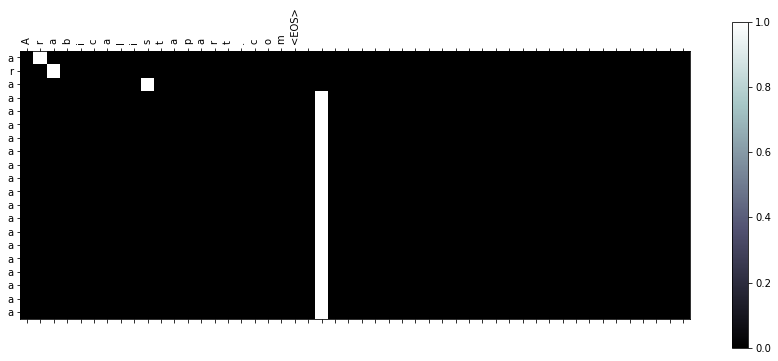

In [125]:
def debug_show_attention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='bone')
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    # Set up axes
    #ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_xticklabels([''] + input_sentence + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1))

    plt.show()
    
def debug_eval_sample_show_attention():
    output, decoded_output, decoder_attns_arr, sample = test_model_single_sample(None, return_more=True)
    print('input:  ', sample[0])
    print('output: ', decoded_output)
    print('target:   ', ' '.join([words_after_common[w] for w in sample[1][:-1]]))

    attns = np.array([arr.data[0].cpu().numpy() for arr in decoder_attns_arr])

    debug_show_attention(list(sample[0]), decoded_output, attns)
    #plt.matshow(attns)
    
debug_eval_sample_show_attention()


In [ ]:
tmp = [r/sum(r) for r in attns]
plt.matshow(tmp)

In [ ]:
np.argmax(attns, 1)
[attns[k,v] for k, v in enumerate(np.argmax(attns, 1))]